In [92]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import utils as utils
import missingno as msno

df = pd.read_csv('../data/raw/dataset.csv', sep=';', low_memory=False)
df.info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non

In [93]:
# Ahora vamos a analizar anomalías, como valores negativos en variables que no tienen sentido, ya que hablan de cantidades que tienen que ser positivas (minutos, llamadas...)

columnas_numericas = df.select_dtypes(include='number').columns.tolist()

columnas_a_excluir = ['change_rev', 'change_mou'] #pueden ser negativas porque son porcentajes de cambio

columnas_finales_a_verificar = [
    col for col in columnas_numericas if col not in columnas_a_excluir
]

resumen, df_negativos = utils.auditar_valores_negativos(df, columnas_finales_a_verificar)

if not df_negativos.empty:
    print("\n--- Procediendo con la limpieza de filas anómalas ---")
    
    # Obtenemos los índices de las filas problemáticas
    indices_a_eliminar = df_negativos.index
    
    # Eliminamos esas filas del DataFrame original
    df_limpio = df.drop(indices_a_eliminar)
    
    print(f"Tamaño original del dataset: {len(df)}")
    print(f"Tamaño del dataset tras la limpieza: {len(df_limpio)}")
    print(f"Filas eliminadas: {len(df) - len(df_limpio)}")
else:
    print("\nEl dataset ya está limpio de valores negativos anómalos.")
    df_limpio = df.copy() # Creamos una copia para seguir trabajando


--- Auditoría de Valores Negativos ---
Se encontraron valores negativos en las siguientes columnas:
- rev_Mean: 5 valores negativos
- totmrc_Mean: 23 valores negativos
- avg6rev: 3 valores negativos
- eqpdays: 133 valores negativos

--- Mostrando filas con al menos un valor negativo detectado ---
       rev_Mean  totmrc_Mean  avg6rev  eqpdays
190    180.2250      149.990    225.0     -3.0
573     81.2250       59.990     49.0     -3.0
810     36.3400       29.990     32.0     -1.0
1371    77.1625       70.000     78.0     -1.0
3631    45.5100       44.990     51.0     -1.0
...         ...          ...      ...      ...
98071  482.0000      148.450    333.0     -1.0
98777   50.2375       59.990     50.0     -3.0
99374  119.1050       83.860     98.0     -3.0
99541  266.8375      152.475    183.0     -3.0
99815    1.8800       -4.840     47.0    352.0

[161 rows x 4 columns]

--- Procediendo con la limpieza de filas anómalas ---
Tamaño original del dataset: 100000
Tamaño del dataset tras

Se han eliminado 161 columnas en total de valores que no tiene sentido que sean negativos. Esto sólo es un 0.161% de los datos que tenemos disponibles, así que podemos seguir trabajando con el dataframe limpio de estos casos.

<Figure size 2580x2580 with 0 Axes>

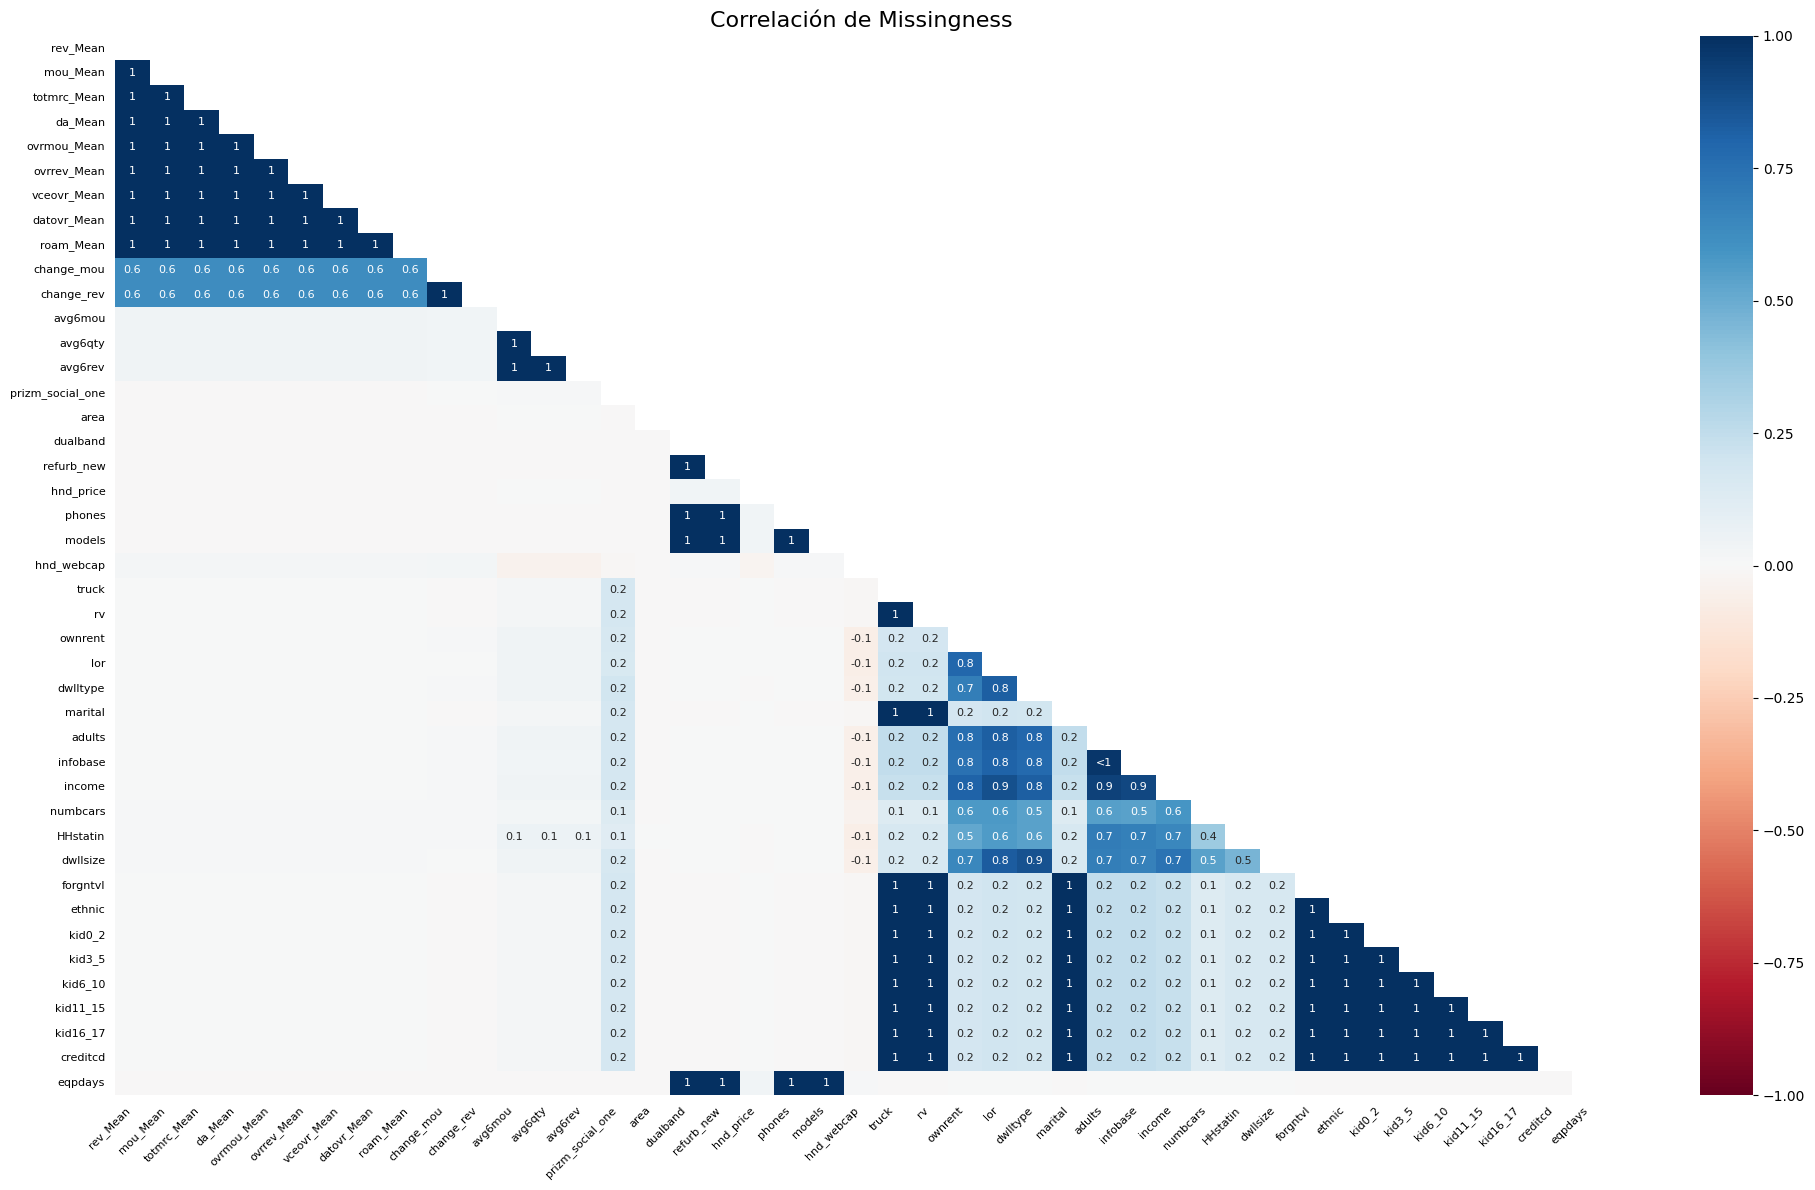

In [94]:
null_info = utils.calcular_nulos(df_limpio)

columns_with_nans = null_info[null_info['Nulos'] > 0].index.tolist()

null_flags_df_subset = df[columns_with_nans].isnull()

missing_patterns_subset = null_flags_df_subset.groupby(null_flags_df_subset.columns.tolist()).size().reset_index(name='count')

print("\n")
    
num_cols = len(columns_with_nans)
recommended_width = max(10, num_cols * 0.6)
recommended_height = max(9, num_cols * 0.6) 

plt.figure(figsize=(recommended_width, recommended_height))
ax = msno.heatmap(df[columns_with_nans], fontsize=10) 

plt.xticks(rotation=45, ha='right', fontsize=8) 
plt.yticks(rotation=0, fontsize=8) 

plt.title('Correlación de Missingness', fontsize=16)
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()
    

Hay una fila que tiene los campos `dualband`, `refurb_new`, `phones`, `models` y `eqpdays` a null, así que la vamos a eliminar. También lo haremos con las líneas con menos nulos como `area`.

In [95]:
df_limpio = df[~df['dualband'].isnull()].copy()

df_limpio = df_limpio[~df_limpio['area'].isnull()].copy()
len(df_limpio)

99959

Hay varios grupos en los que varias columnas son nulas a la vez. Vamos a analizar una a una si su presencia o no está asociada al `churn`.

### 1. Variables asociadas a servicios específicos

Primero generamos una columna binaria que nos especifica si ese registro tenía estas variables a null (1) o no (0).

In [96]:
cols_services_null = ['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean']

# Sabemos que con que una sea nula, el resto también lo son.
utils.crear_flag_nulos(df_limpio, 'rev_Mean', 'services_null')

Número de 1s en la nueva columna flag: services_null
1    357
Name: count, dtype: int64



,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,services_null
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,N,U,U,U,U,U,Y,361.0,1000001,0
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,Z,U,U,U,U,U,Y,240.0,1000002,0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,N,U,Y,U,U,U,Y,1504.0,1000003,0
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,U,Y,U,U,U,U,Y,1812.0,1000004,0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,I,U,U,U,U,U,Y,434.0,1000005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,S,U,U,U,Y,U,Y,773.0,1099996,1
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,N,U,U,Y,Y,Y,Y,835.0,1099997,1
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,U,Y,Y,U,U,U,N,433.0,1099998,1
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,S,U,U,U,U,U,N,75.0,1099999,1


--- Análisis de Churn para la Variable Categórica: 'services_null' ---
               Tasa de Churn  Total Clientes
services_null                               
1                   0.686275             357
0                   0.494880           99602




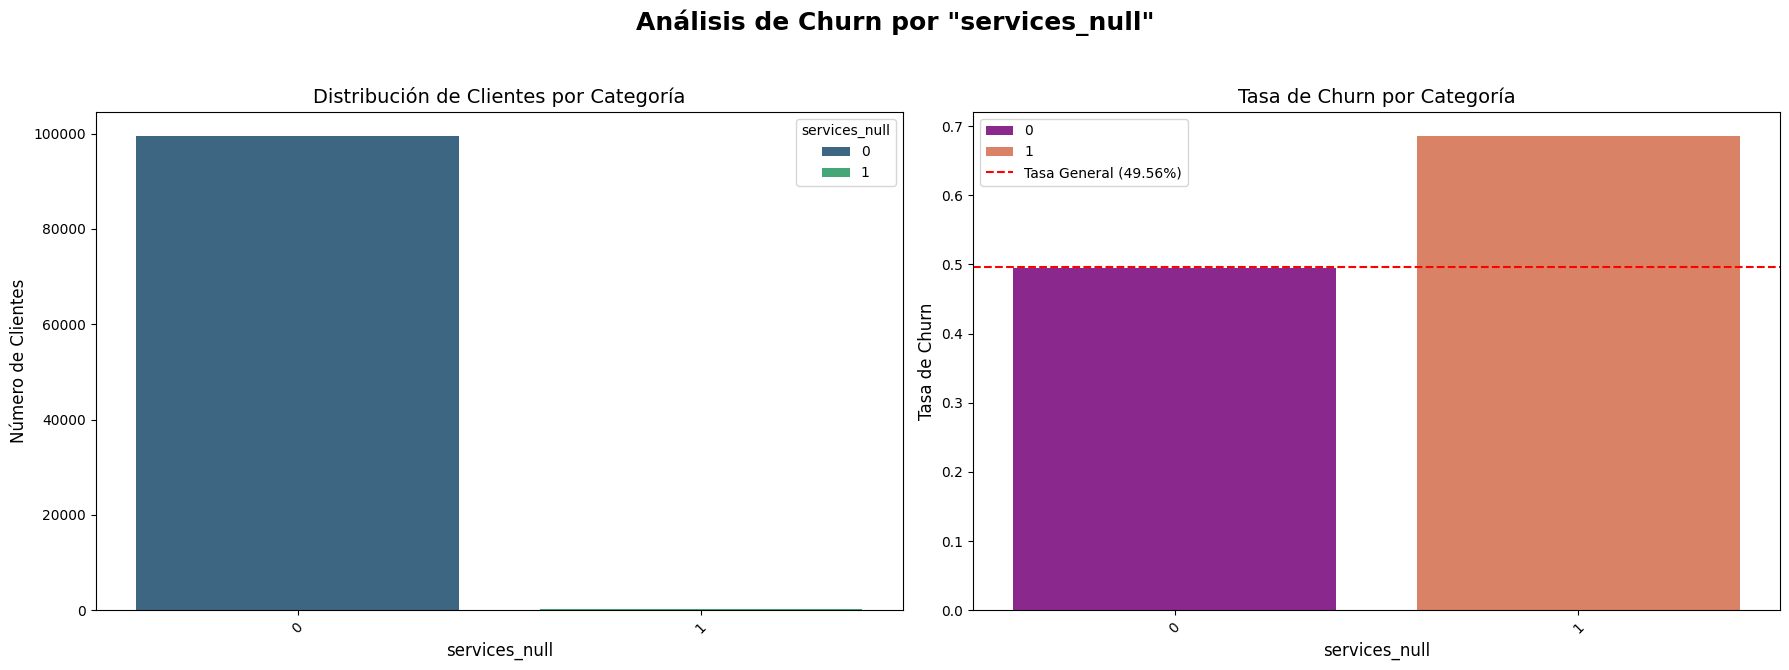

In [97]:
# Ahora observamos si esta variable está asociada al churn
utils.analizar_churn_categorica(df_limpio, 'services_null')

Observamos que la gente que tenía este valor implementado (los que services_null = 0) tienen un abandono acorde con la media, mientras que los que no lo tienen implementado, lo tienen más alto. Esto puede ser debido a que las variables que son nulas a la vez, corresponden a gente que no ha usado servicios extra (roaming, exceso de uso de servicios de voz, de datos, etc). Esto puede indicar que usan poco el servicio, y realmente de manera eventual, decidan darse de baja.

Ahora nos gustaría analizar cómo afectan estas variables a aquellos valores no nulos, para saber cuáles son descartables y cuáles no.

/home/paloma/churn-estimation/notebooks/utils.py:390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(
/home/paloma/churn-estimation/notebooks/utils.py:390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(
/home/paloma/churn-estimation/notebooks/utils.py:390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

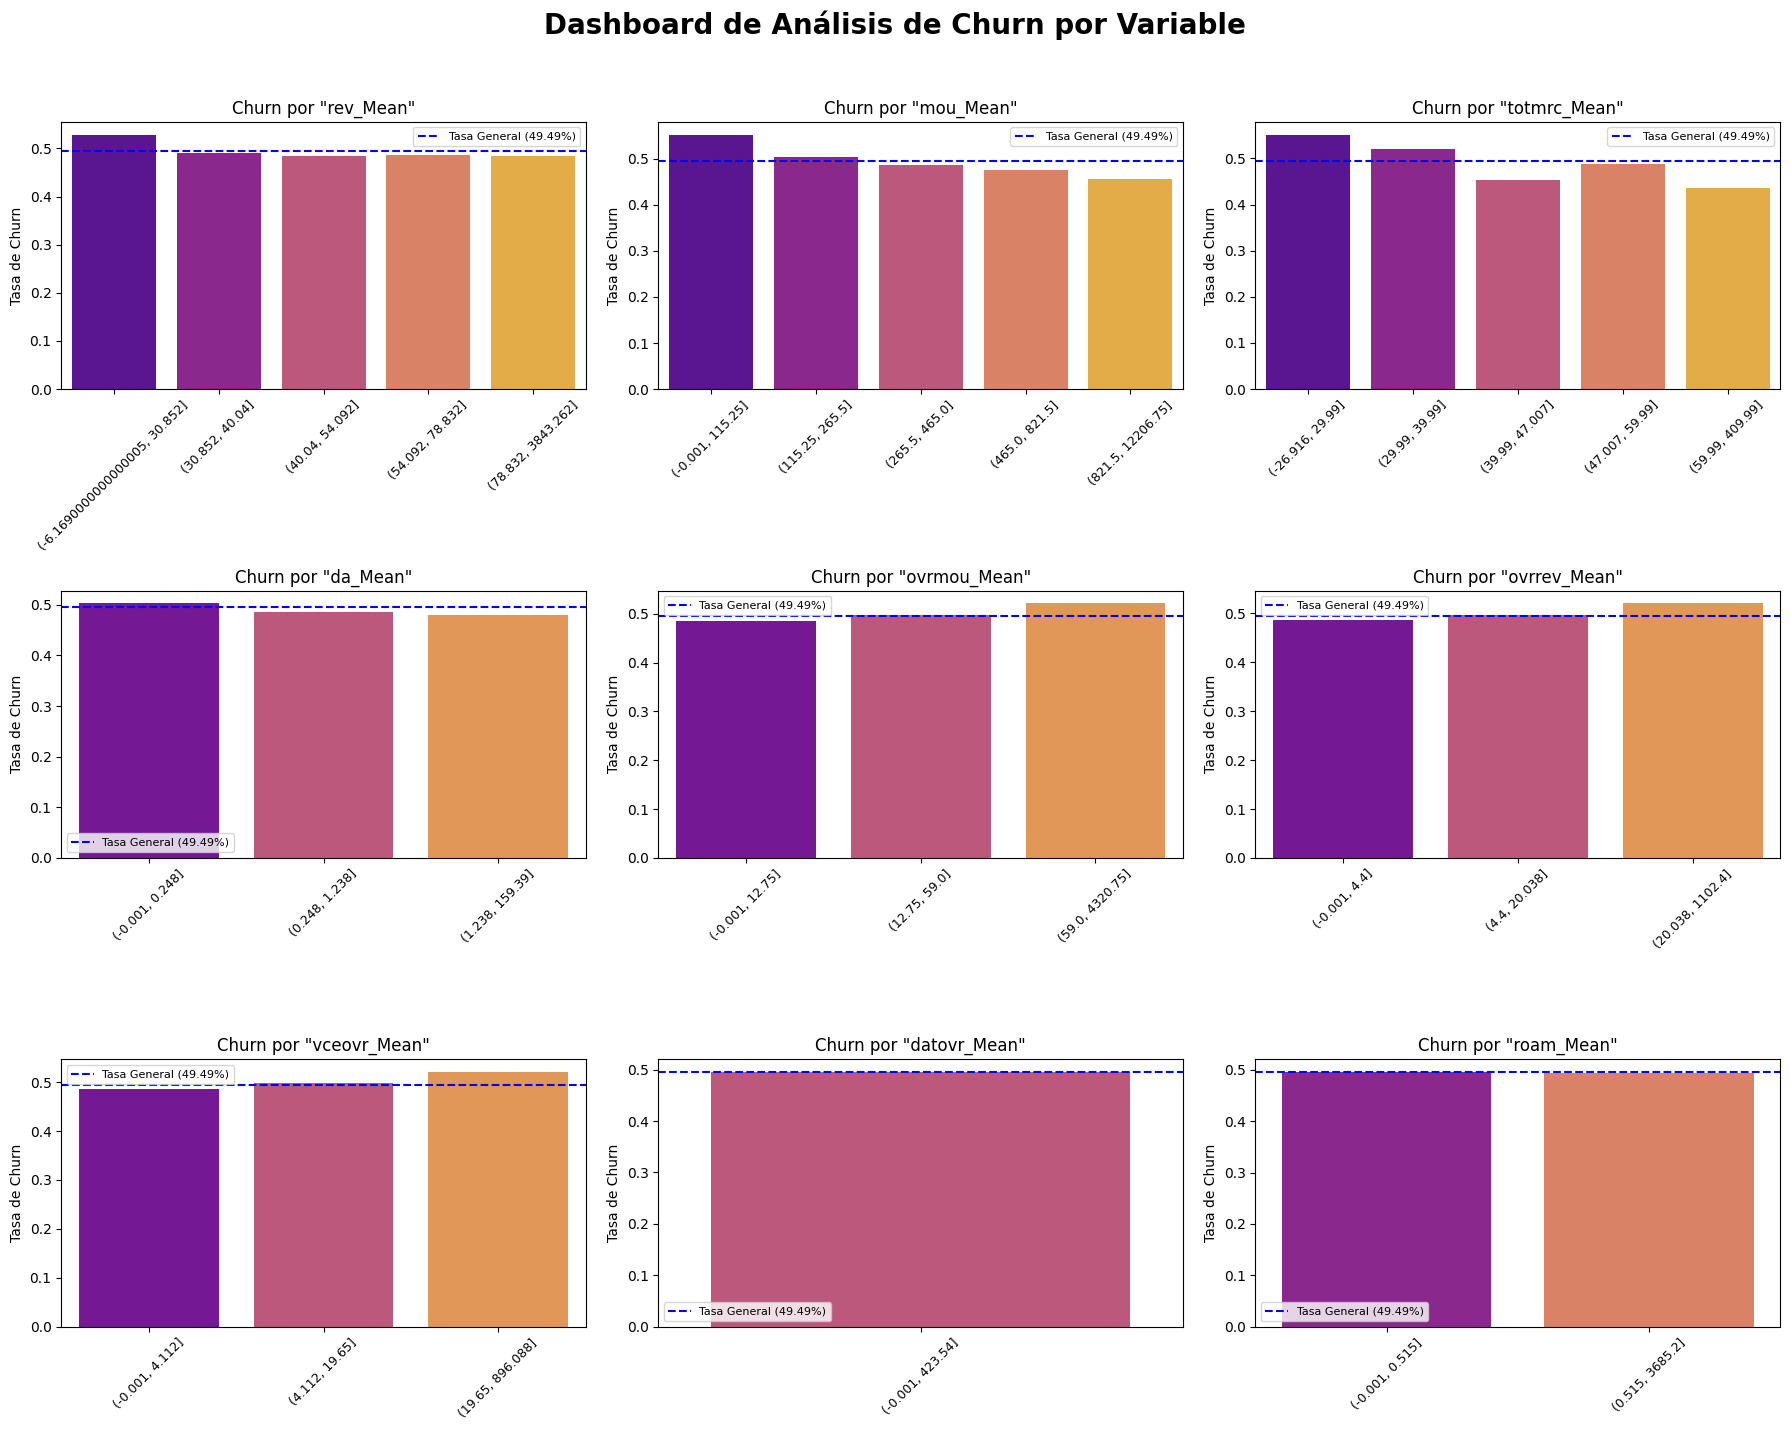

In [98]:
# Obtenemos los usuarios donde están rellenadas estas variables
df_services = df_limpio[df_limpio['services_null'] == 0]

n_cols = len(cols_services_null)
n_layout_cols = 3  # Gráficos por fila (puedes cambiarlo a 2, 3, o 4)
n_layout_rows = (n_cols + n_layout_cols - 1) // n_layout_cols # Cálculo automático de filas

# 3. Crea la figura y los subplots
fig, axes = plt.subplots(n_layout_rows, n_layout_cols, figsize=(n_layout_cols * 6, n_layout_rows * 5))
fig.suptitle('Dashboard de Análisis de Churn por Variable', fontsize=20, weight='bold')

# 'axes' es una matriz de subplots, la aplanamos para iterar fácilmente
axes = axes.flatten()

# 4. Itera sobre las columnas y dibuja cada gráfico en su subplot correspondiente
for i, columna in enumerate(cols_services_null):
    ax = axes[i]
    if is_numeric_dtype(df_services[columna]):
        utils.plot_tasa_churn_numerica(df_services, columna, ax)
    else:
        utils.plot_tasa_churn_categorica(df_services, columna, ax)

for i in range(n_cols, len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Ajustar para el título principal
plt.show()

En las cuatro primeras variables, `rev_Mean`, `mou_Mean`, `totmrc_Mean` y `da_Mean` observamos más tendencia de los usuarios a permanecer según aumentan los valores: estas variables están asociadas a lo que se les cobra, a los minutos de uso y a las llamadas asistidas. Los usuarios que menos pagan tienen más tendencia a irse, dándonos una señal de que posiblemente las tarifas bajas no sean competitivas con el mercado, ya que les podría seguir pareciendo lo suficientemente altas como para irse. Sin embargo, esto no sucede según aumenta el precio, ya que posiblemente en comparación con el uso que se le da, las tarifas sí que ofrecen una buena oferta. Esto quiere decir que hay que poner foco en aquellas personas con tarifas más bajas.

En las variables `ovrmou_Mean`, `ovrrev_Mean` y `vceovr_Mean` vemos una tendencia contraria: cuanto más se les carga por estos servicios, más probabilidad de irse. Al final tiene sentido, ya que son cargos extra que se añaden a la tarifa, y eso puede hacer que el usuario esté disconforme y prefiera irse a otro lado. Posiblemente requiera un aumento de tarifa o una mejora del servicio, incluyendo otro tipo de servicios extra o aumentando la cantidad de minutos utilizar, por ejemplo.

Las variables `datover_Mean` y `roam_Mean` no suponen un indicador del churn, así que podríamos prescindir de ellas. De hecho, en la de datos, casi todos los usuarios están en valores alrededor de 0, por eso los outliers que están, que llegan al máximo, son representados también en la misma barra.

Como los nulos de estas variables son pocos, vamos a asumir que se refieren a nada de uso (imputación por 0), ya que sólo estaríamos modificando el primer bin de las gráficas 0.357%.

In [99]:
df_limpio[cols_services_null] = df_limpio[cols_services_null].fillna(0)

null_info = utils.calcular_nulos(df_limpio)

print(null_info[null_info['Nulos']>0])

                  Nulos  Porcentaje
change_mou          891    0.891365
change_rev          891    0.891365
avg6mou            2837    2.838164
avg6qty            2837    2.838164
avg6rev            2837    2.838164
prizm_social_one   7386    7.389030
hnd_price           846    0.846347
hnd_webcap        10185   10.189178
truck              1732    1.732710
rv                 1732    1.732710
ownrent           33694   33.707820
lor               30177   30.189378
dwlltype          31898   31.911084
marital            1732    1.732710
adults            23010   23.019438
infobase          22070   22.079052
income            25426   25.436429
numbcars          49350   49.370242
HHstatin          37906   37.921548
dwllsize          38293   38.308707
forgntvl           1732    1.732710
ethnic             1732    1.732710
kid0_2             1732    1.732710
kid3_5             1732    1.732710
kid6_10            1732    1.732710
kid11_15           1732    1.732710
kid16_17           1732    1

### 2. Variables categóricas

In [100]:
cols_cat_null = ['truck', 'rv', 'marital', 'forgntvl', 'ethnic', 'creditcd', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17']

utils.crear_flag_nulos(df_limpio, 'truck', 'cat_null')

Número de 1s en la nueva columna flag: cat_null
1    1732
Name: count, dtype: int64



,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,services_null,cat_null
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,U,U,U,U,U,Y,361.0,1000001,0,0
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,U,U,U,U,U,Y,240.0,1000002,0,0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,U,Y,U,U,U,Y,1504.0,1000003,0,0
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,Y,U,U,U,U,Y,1812.0,1000004,0,0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,U,U,U,U,U,Y,434.0,1000005,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0000,0.00,0.000,0.0000,0.00,0.0,0.0,0.0,0.0,NaN,...,U,U,U,Y,U,Y,773.0,1099996,1,0
99996,0.0000,0.00,0.000,0.0000,0.00,0.0,0.0,0.0,0.0,NaN,...,U,U,Y,Y,Y,Y,835.0,1099997,1,0
99997,0.0000,0.00,0.000,0.0000,0.00,0.0,0.0,0.0,0.0,NaN,...,Y,Y,U,U,U,N,433.0,1099998,1,0
99998,0.0000,0.00,0.000,0.0000,0.00,0.0,0.0,0.0,0.0,NaN,...,U,U,U,U,U,N,75.0,1099999,1,0


--- Análisis de Churn para la Variable Categórica: 'cat_null' ---
          Tasa de Churn  Total Clientes
cat_null                               
0              0.495862           98227
1              0.478637            1732




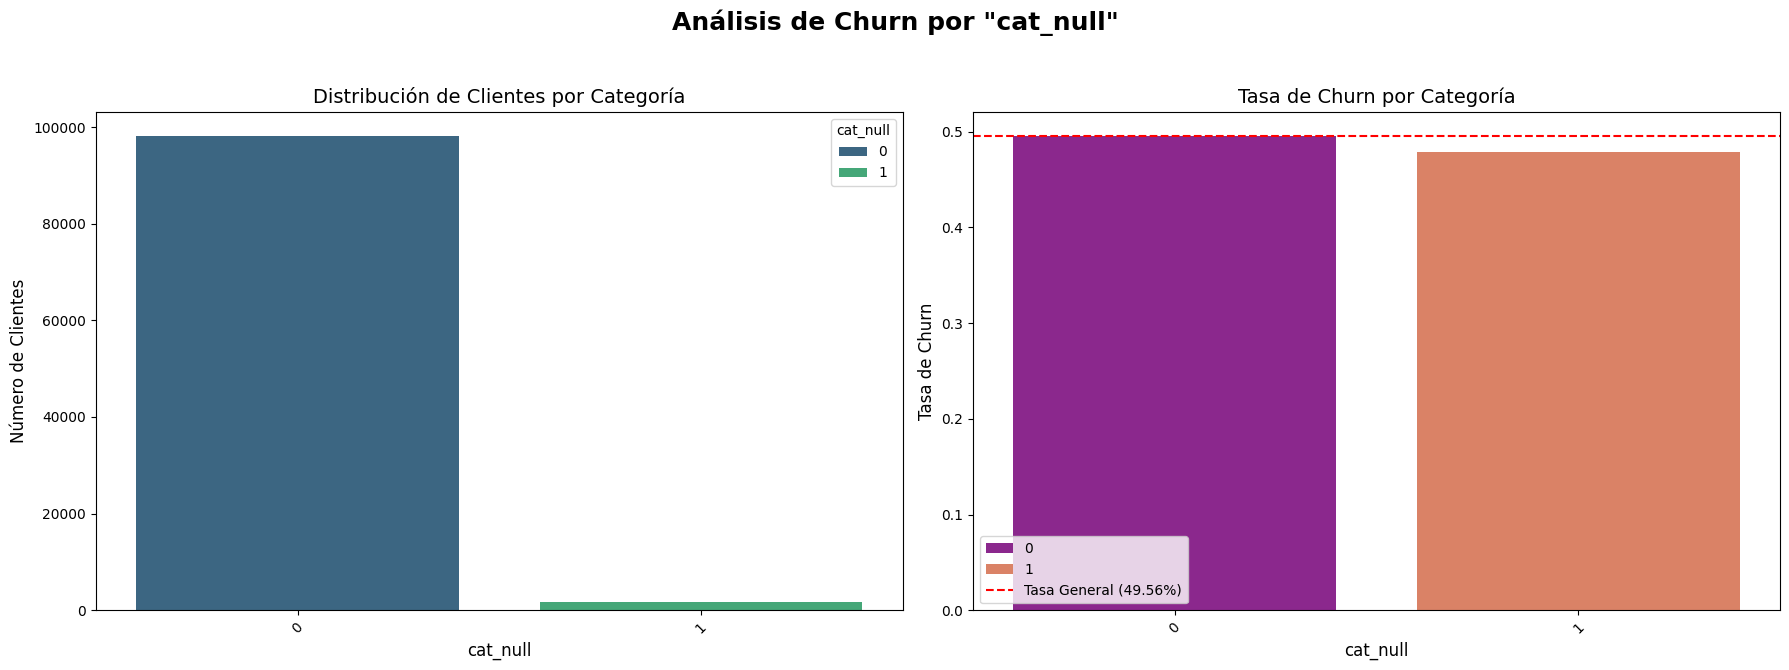

In [101]:
utils.analizar_churn_categorica(df_limpio, 'cat_null')

Al estar gestionando variables categóricas, vamos a generar otra categoría llamada "UNKN" para que entre dentro del estudio.

In [102]:
df_limpio[cols_cat_null] = df_limpio[cols_cat_null].fillna('UNKN')

De la variable de los podemos llegar a saber quién tiene al menos 1, 2, 3... hijos, ya que no se especifica el número en cada columna.

In [103]:
kid_cols = [col for col in df_limpio.columns if col.startswith('kid')]

df_limpio['num_hijos_minimo'] = (df_limpio[kid_cols] == 'Y').sum(axis=1)


La ausencia de estas variables hace que el abandono sea sutilmente más bajo que la media normal. Así que podría ser un indicador. Ahora, seguimos como antes, analizando los valores de las variables que no son nulas.

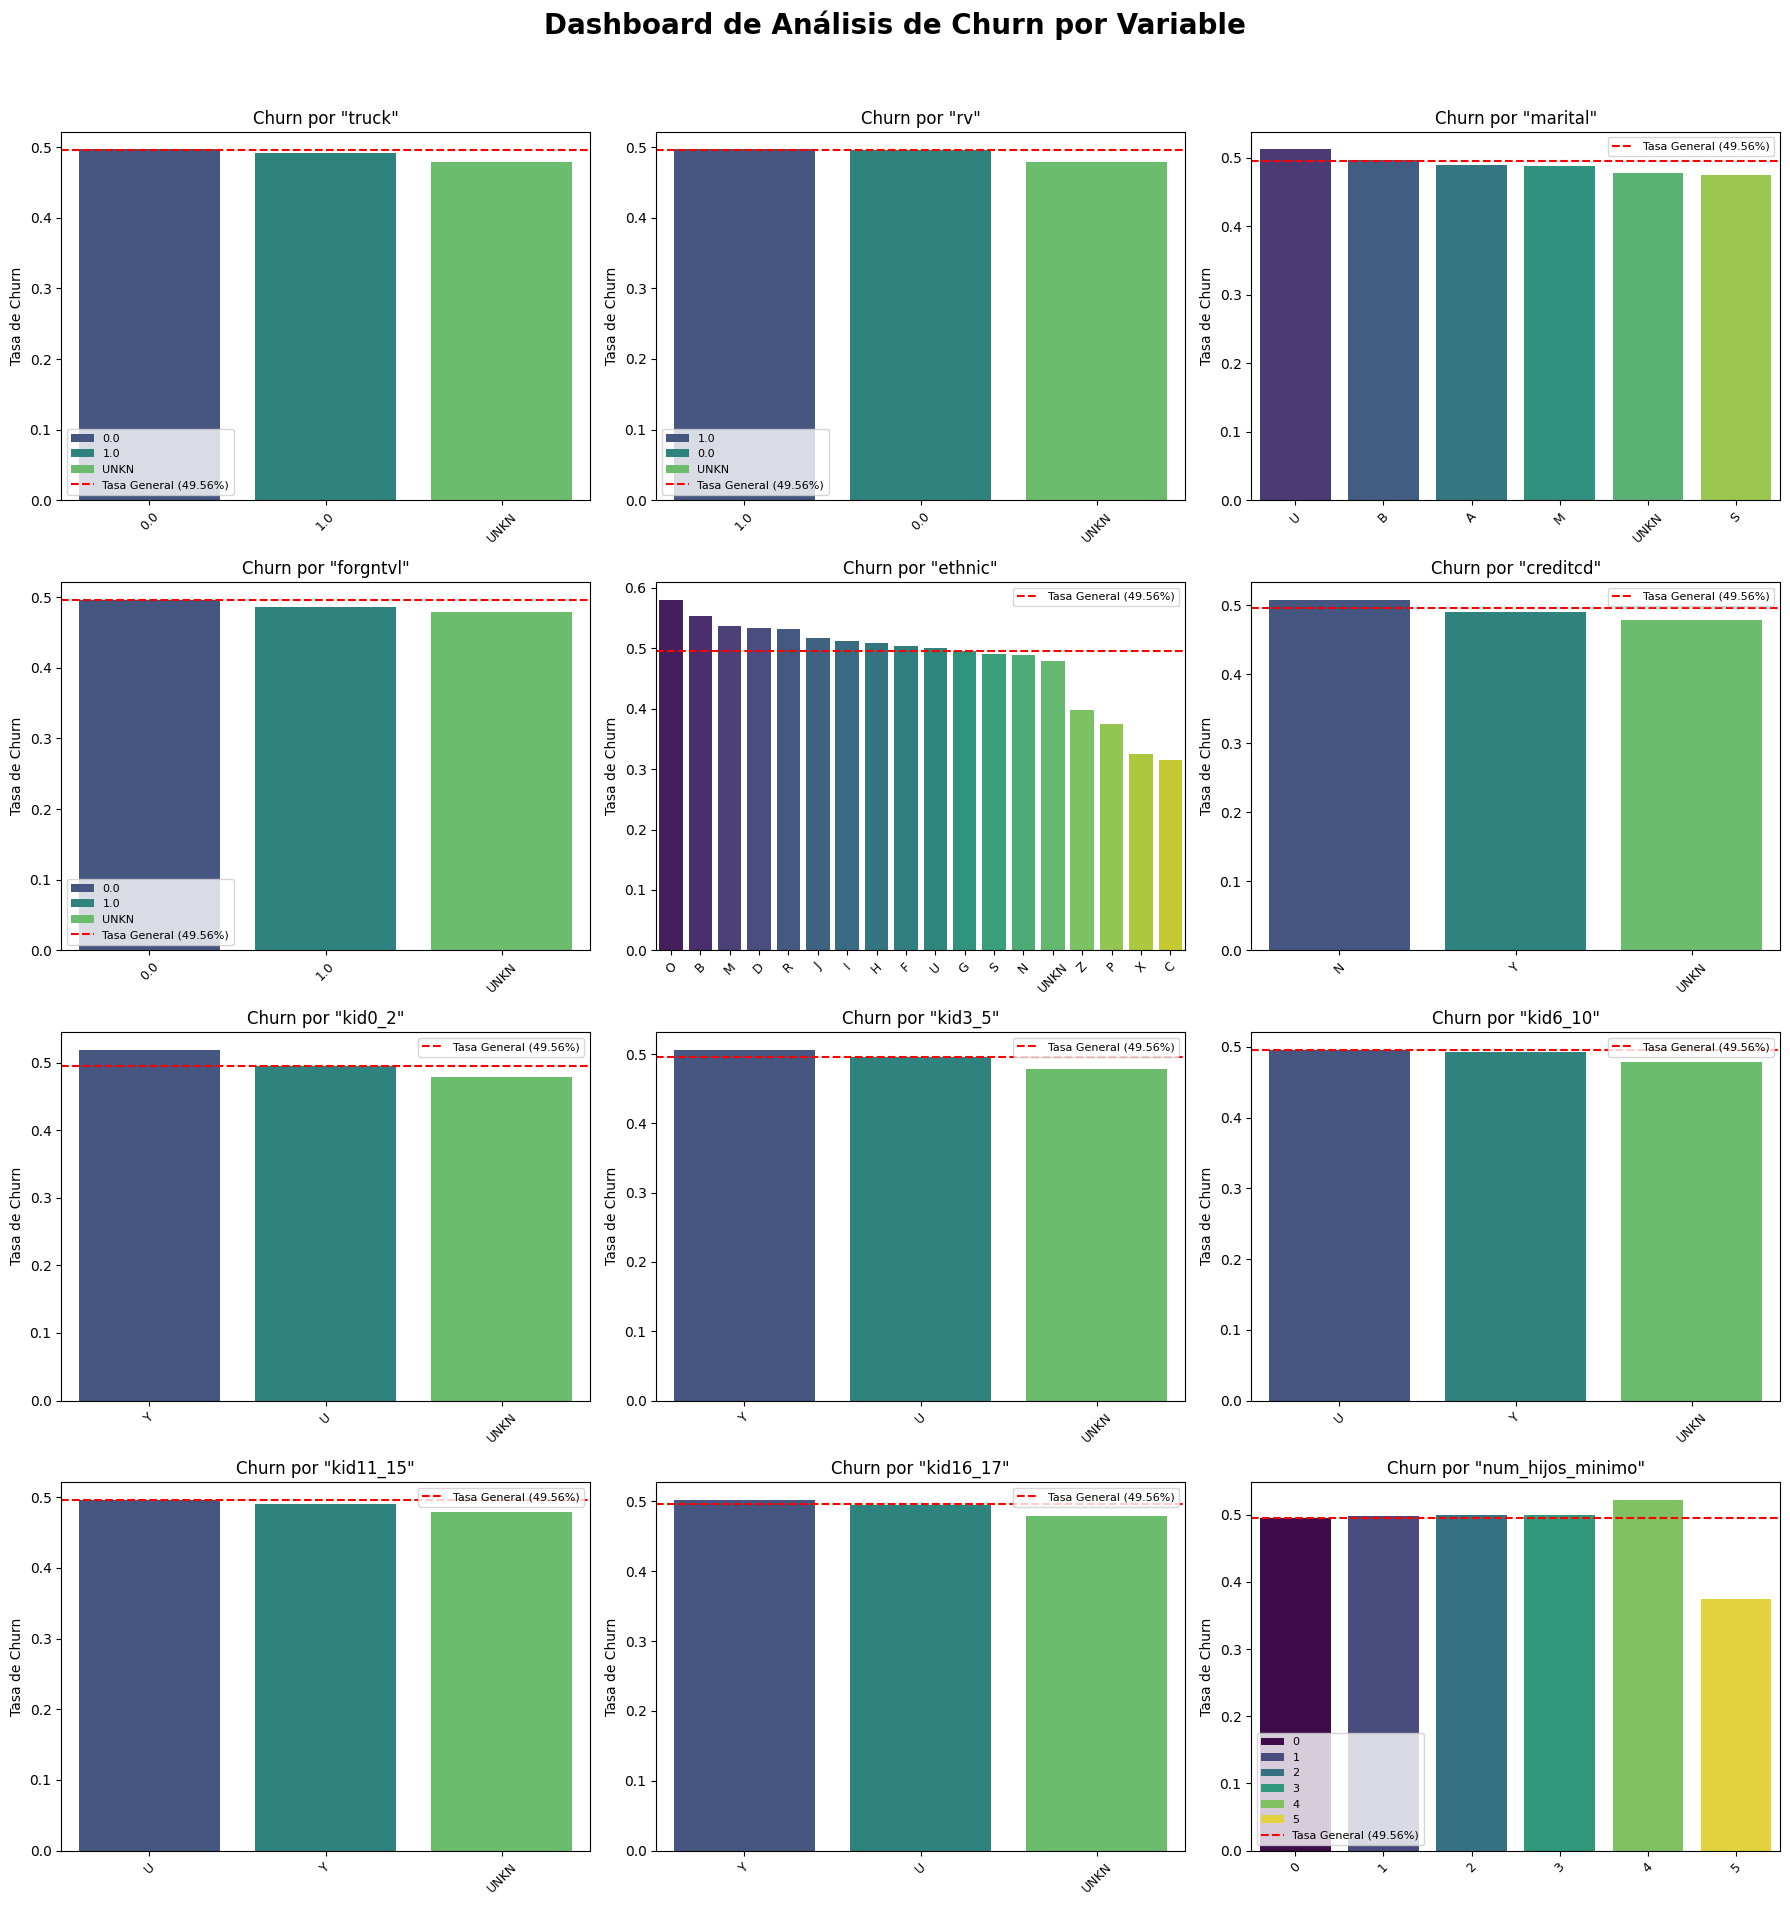

In [104]:
# Obtenemos los usuarios donde están rellenadas estas variables
#df_cat = df_limpio[df_limpio['cat_null'] == 0]

n_cols = len(cols_cat_null + ['num_hijos_minimo'])

n_zayout_cols = 3  # Gráficos por fila (puedes cambiarlo a 2, 3, o 4)
n_layout_rows = (n_cols + n_layout_cols - 1) // n_layout_cols # Cálculo automático de filas

# 3. Crea la figura y los subplots
fig, axes = plt.subplots(n_layout_rows, n_layout_cols, figsize=(n_layout_cols * 6, n_layout_rows * 5))
fig.suptitle('Dashboard de Análisis de Churn por Variable', fontsize=20, weight='bold')

# 'axes' es una matriz de subplots, la aplanamos para iterar fácilmente
axes = axes.flatten()

for i, columna in enumerate(cols_cat_null + ['num_hijos_minimo']):
    ax = axes[i]
    utils.plot_tasa_churn_categorica(df_limpio, columna, ax)

for i in range(n_cols, len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Ajustar para el título principal
plt.show()

Tener camión o una autocaravana no parece impactar demasiado en el abandono, pero sí el haber viajadoal extranjero. La gente que ha viajado puede tener más posibilidad de abandono: habrá que fijarse en las tarifas de roaming, por ejemplo.

Los usuarios con tarjeta de crédito tienen más fidelidad que aquellos que no la tienen.

En la categoría de estado civil, no sabemos a qué corresponde cada variable. Sin embargo, se observa que el grupo 'U' tiene mayor tendencia al abandono mientras que A, M y S van aumentando en fidelidad. Otro factor es la etnia, donde varias de las categorías representan un gran aumento del abandono, y otras tantas muestran alta fidelidad. Habrá también que analizarlo en profundidad. 

Tener hijos muy pequeños (0-2) o más mayores (16-17) sí que parece afectar al abandono, pero no notablemente. Eso sí, la variable conjunta del número de hijos parece indicar que tener 4 hijos aumenta mucho el abandono, mientras que tener 5 da mucha fidelidad. Sin embargo, esto podría no tener sentido y pertenecer a outliers, lo que requerirá una observación en más profundidad.

### 2A. Variable de estado civil

--- Análisis de Churn para la Variable Categórica: 'marital' ---
         Tasa de Churn  Total Clientes
marital                               
U             0.512528           37317
B             0.496908            7114
A             0.489689            5140
M             0.488641           31033
UNKN          0.478637            1732
S             0.474664           17623




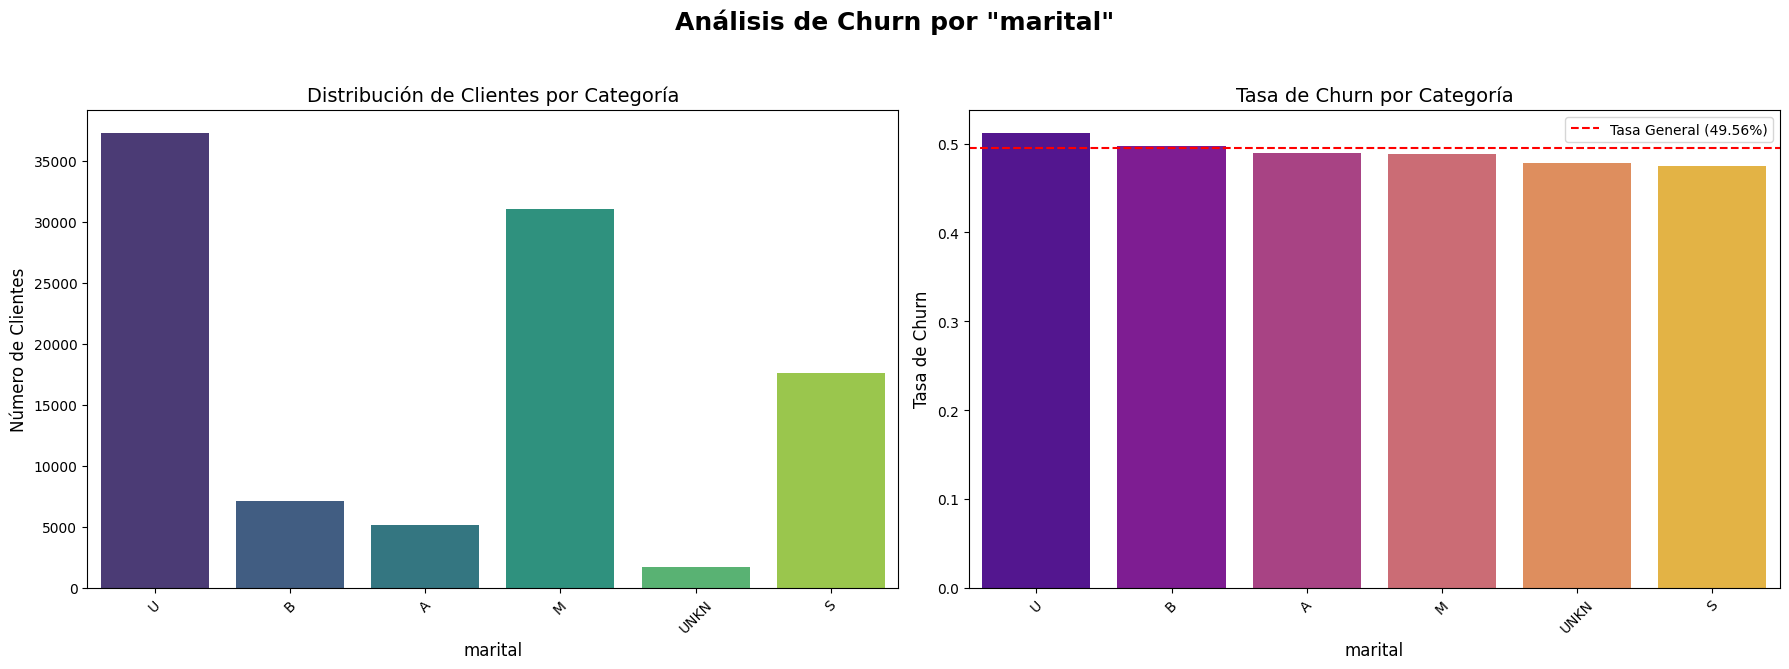

In [105]:
utils.analizar_churn_categorica(df_limpio, 'marital')

### 2B. Variable tarjeta

--- Análisis de Churn para la Variable Categórica: 'creditcd' ---
          Tasa de Churn  Total Clientes
creditcd                               
N              0.508236           31023
Y              0.490149           67204
UNKN           0.478637            1732




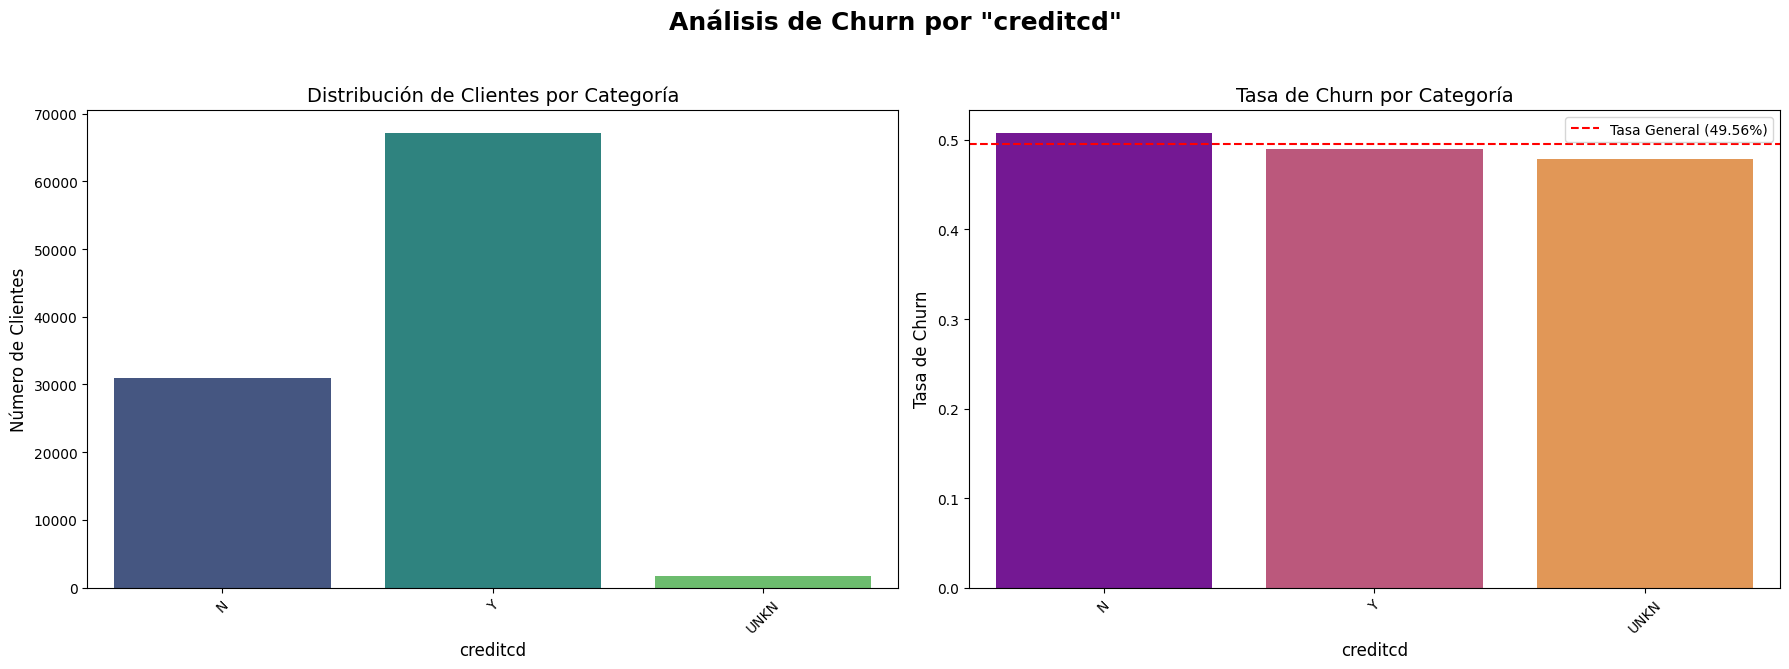

In [106]:
utils.analizar_churn_categorica(df_limpio, 'creditcd')

### 2C. Variable viaje al extranjero

--- Análisis de Churn para la Variable Categórica: 'forgntvl' ---
          Tasa de Churn  Total Clientes
forgntvl                               
0.0            0.496488           92532
1.0            0.485689            5695
UNKN           0.478637            1732




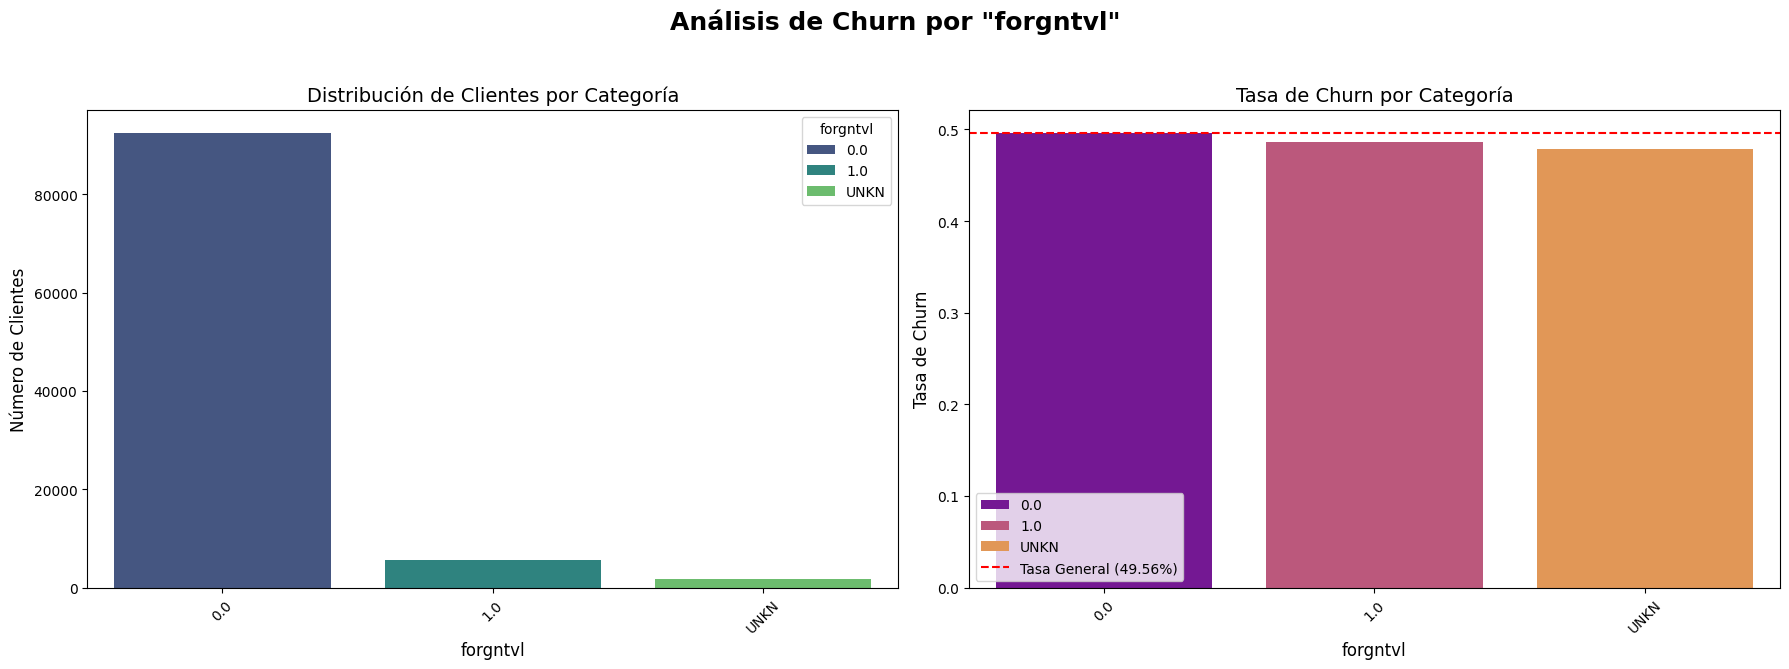

In [107]:
utils.analizar_churn_categorica(df_limpio, 'forgntvl')

### 2D. Variable etnia

--- Análisis de Churn para la Variable Categórica: 'ethnic' ---
        Tasa de Churn  Total Clientes
ethnic                               
O            0.580591            4194
B            0.553130            1374
M            0.536913             149
D            0.533487             866
R            0.532057            1045
J            0.516209            2838
I            0.512080            3808
H            0.508297           13620
F            0.504000            2125
U            0.500091           10940
G            0.495770            5910
S            0.491212           12744
N            0.488419           33375
UNKN         0.478637            1732
Z            0.397016            4423
P            0.374486             486
X            0.325581              86
C            0.315574             244




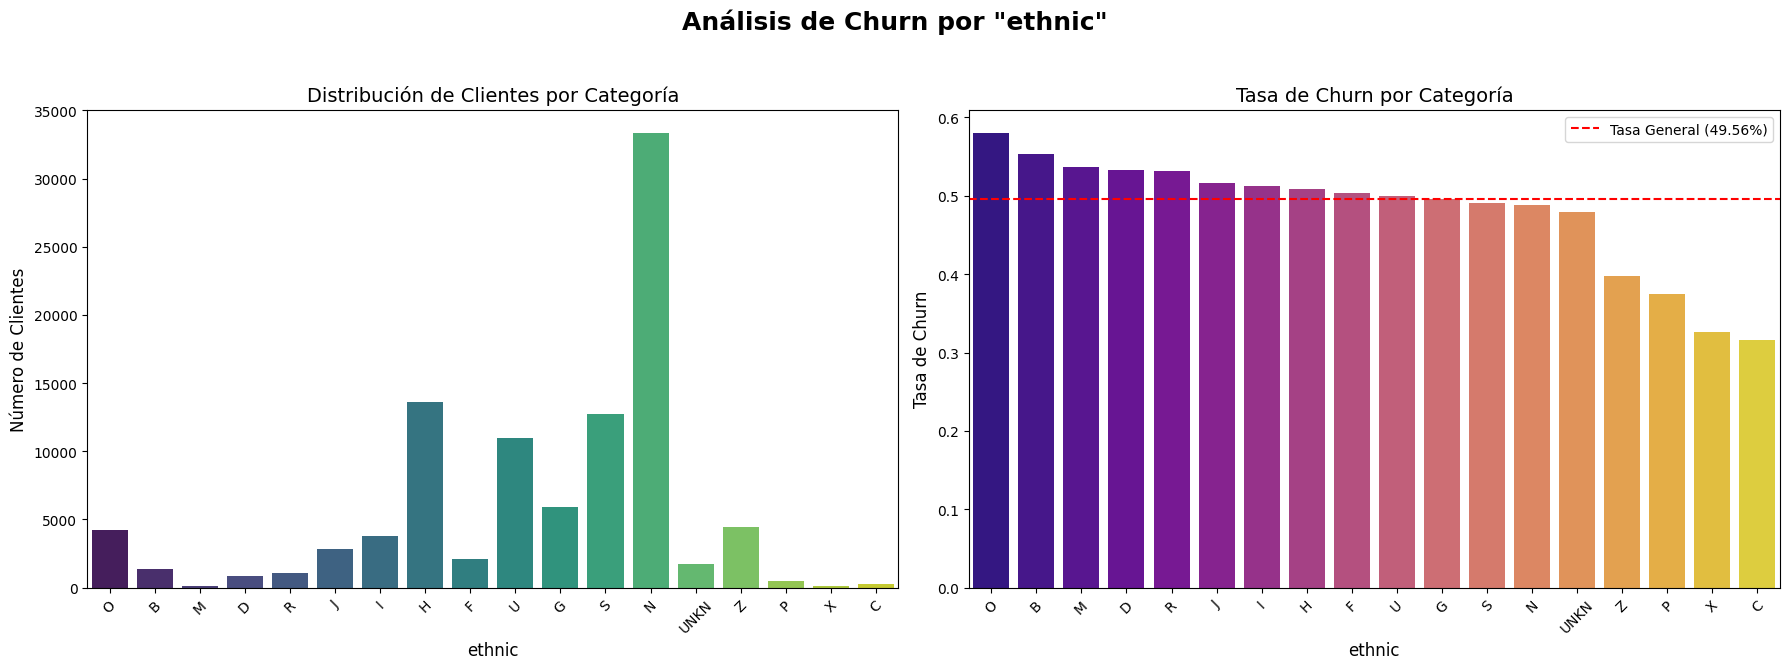

In [108]:
utils.analizar_churn_categorica(df_limpio, 'ethnic')

### 2E. Variable hijos minimos

--- Análisis de Churn para la Variable Categórica: 'num_hijos_minimo' ---
                  Tasa de Churn  Total Clientes
num_hijos_minimo                               
4                      0.522124             226
3                      0.500000            1920
2                      0.499738            7628
1                      0.498411           13531
0                      0.494481           76638
5                      0.375000              16




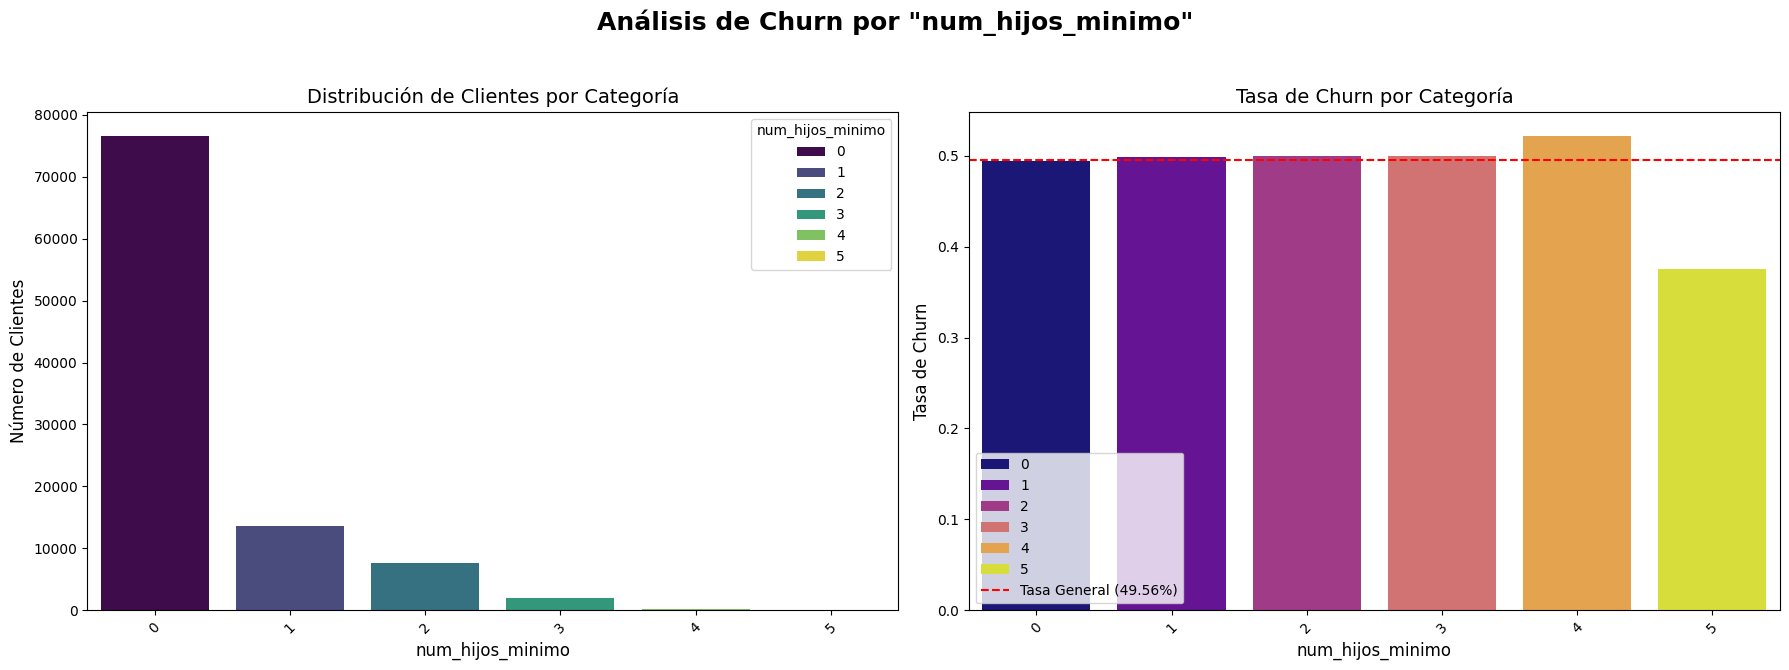

In [109]:
utils.analizar_churn_categorica(df_limpio, 'num_hijos_minimo') #Asumiendo que desconocerlo es no tenerlo

In [110]:
null_info = utils.calcular_nulos(df_limpio)

print(null_info[null_info['Nulos']>0])

                  Nulos  Porcentaje
change_mou          891    0.891365
change_rev          891    0.891365
avg6mou            2837    2.838164
avg6qty            2837    2.838164
avg6rev            2837    2.838164
prizm_social_one   7386    7.389030
hnd_price           846    0.846347
hnd_webcap        10185   10.189178
ownrent           33694   33.707820
lor               30177   30.189378
dwlltype          31898   31.911084
adults            23010   23.019438
infobase          22070   22.079052
income            25426   25.436429
numbcars          49350   49.370242
HHstatin          37906   37.921548
dwllsize          38293   38.308707


### 3. Cambios respecto a los tres meses anteriores

Número de 1s en la nueva columna flag: change_null
1    891
Name: count, dtype: int64

--- Análisis de Churn para la Variable Categórica: 'change_null' ---
             Tasa de Churn  Total Clientes
change_null                               
1                 0.760943             891
0                 0.493176           99068




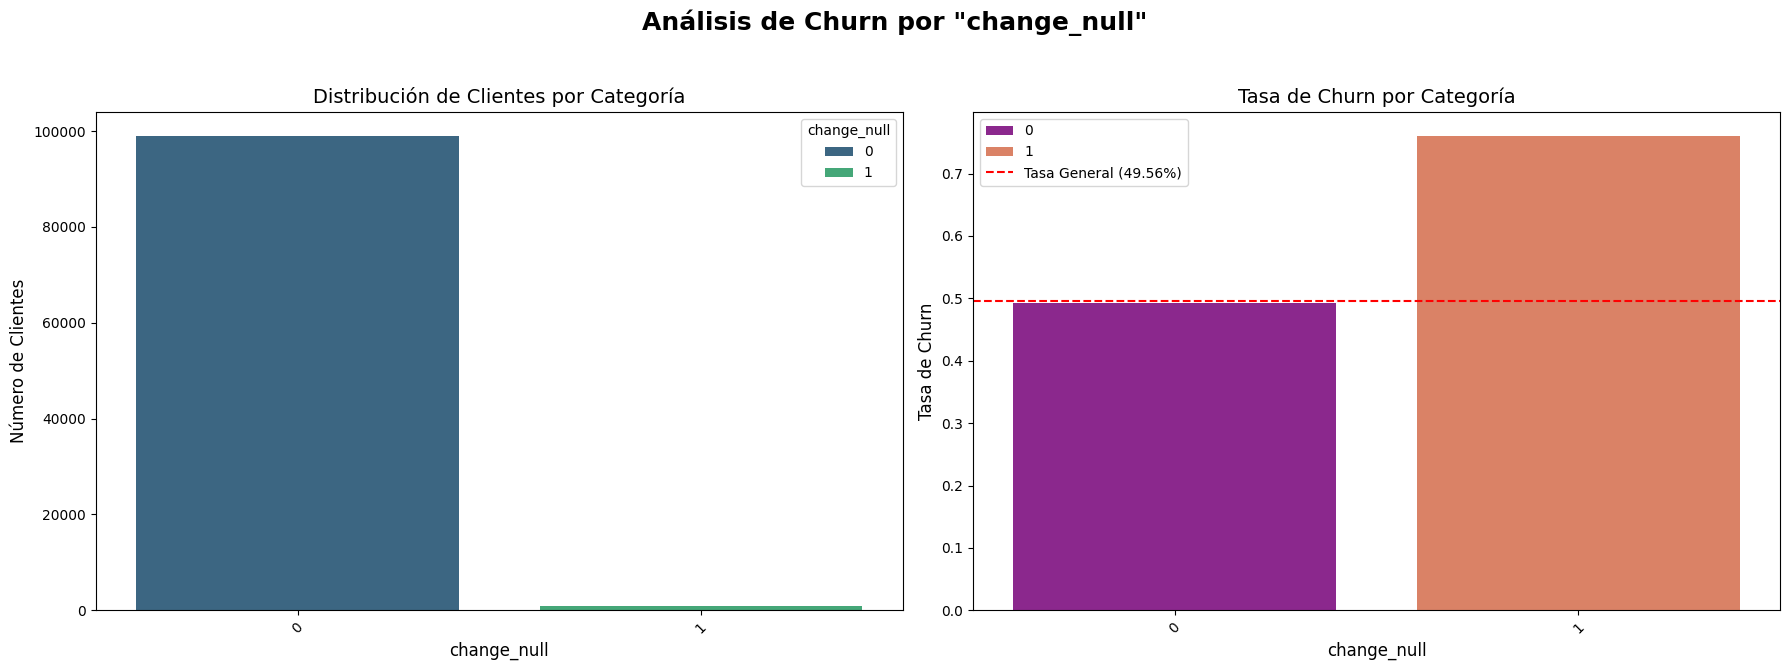

In [111]:
cols_Mean_null = ['change_mou', 'change_rev']

utils.crear_flag_nulos(df_limpio, 'change_mou', 'change_null')

utils.analizar_churn_categorica(df_limpio, 'change_null', target='churn')

En esta variable vemos que es el abandono de la gente que no tenía este apartado relleno es muy alto. Podría ser debido a la inactividad de los 3 meses anteriores, ya que si tenemos 0, la división por este número es indeterminado. Para ello, vamos a observar qué valor tienen las variables `avg3mou` y `avg3rev` para los casos en los que los campos `change_mou` y `change_rev` no existen.

In [112]:
df_change_nulos = df_limpio[df_limpio['change_mou'].isnull()].copy()

columnas_a_inspeccionar = ['avg3mou', 'avg3rev']

resumen_estadistico = df_change_nulos[columnas_a_inspeccionar].describe()
print(resumen_estadistico)
print(df_change_nulos[columnas_a_inspeccionar].head(10))

          avg3mou     avg3rev
count   891.00000  891.000000
mean    438.08193   56.570146
std     503.82615   56.365803
min       0.00000    1.000000
25%      79.00000   26.000000
50%     296.00000   40.000000
75%     587.50000   69.000000
max    5768.00000  849.000000
      avg3mou  avg3rev
156       545       96
224      1403      142
231         1       10
349      1058       50
883       662       53
918       109       23
978      2540      205
1272        3       11
1292      721       51
1334        7       17


Esto nos deja ver que realmente sí que son usuarios activos, pero sin duda es producto de algo que deja desconforme a los usuarios. En estas variables de cambio, estaría también el revenue y los minutos de uso del mes actual, pero ese dato no lo tenemos. No sabemos sobre qué periodos están calculados `rev_Mean` y `mou_Mean`, así que esto seguramente venga de un problema más importante en la facturación del mes.

Vamos a inspeccionar la variable `eqpdays`, que se refiere a la novedad del teléfono actual.

In [113]:
# 'df_change_nulos' es el subconjunto donde change_mou es nulo
df_change_nulos = df_limpio[df_limpio['change_mou'].isnull()]

# 'df_change_ok' es el resto de la población
df_change_ok = df_limpio[df_limpio['change_mou'].notna()]

print("--- Resumen de Antigüedad del Teléfono ('eqpdays') ---")

print("\nPara el grupo con 'change' NULO (891 clientes):")
print(df_change_nulos['eqpdays'].describe())

print("\nPara el grupo NORMAL (el resto de clientes):")
print(df_change_ok['eqpdays'].describe())

--- Resumen de Antigüedad del Teléfono ('eqpdays') ---

Para el grupo con 'change' NULO (891 clientes):
count     891.000000
mean      536.984287
std       351.972659
min         1.000000
25%       284.000000
50%       459.000000
75%       778.000000
max      1813.000000
Name: eqpdays, dtype: float64

Para el grupo NORMAL (el resto de clientes):
count    99068.000000
mean       390.649867
std        255.102745
min         -5.000000
25%        211.000000
50%        341.000000
75%        528.000000
max       1823.000000
Name: eqpdays, dtype: float64


In [114]:
tendencia_uso_3m_vs_6m_nulos = df_change_nulos['avg3mou'] - df_change_nulos['avg6mou']
tendencia_uso_3m_vs_6m_ok = df_change_ok['avg3mou'] - df_change_ok['avg6mou']

print(tendencia_uso_3m_vs_6m_nulos.describe())
print(tendencia_uso_3m_vs_6m_ok.describe())

tendencia_rev_3m_vs_6m_nulos = df_change_nulos['avg3rev'] - df_change_nulos['avg6rev']
tendencia_rev_3m_vs_6m_ok = df_change_ok['avg3rev'] - df_change_ok['avg6rev']

print(tendencia_rev_3m_vs_6m_nulos.describe())
print(tendencia_rev_3m_vs_6m_ok.describe())

count     813.000000
mean      -42.041820
std       169.846325
min     -1048.000000
25%       -85.000000
50%       -13.000000
75%        22.000000
max       747.000000
dtype: float64
count    96309.000000
mean         6.985796
std        145.028311
min      -2528.000000
25%        -37.000000
50%          2.000000
75%         51.000000
max       2284.000000
dtype: float64
count    813.000000
mean      -3.985240
std       23.520922
min     -156.000000
25%      -12.000000
50%       -3.000000
75%        1.000000
max      138.000000
dtype: float64
count    96309.000000
mean         0.435307
std         19.103612
min       -774.000000
25%         -3.000000
50%          0.000000
75%          3.000000
max        738.000000
dtype: float64


Con estos valores podemos ver que los usuarios cuyo cálculo es nulo, tienen un cambio drástico de uso en comparación con el resto de usuarios. En general, en los últimos 3 meses, la media de consumo ha bajado con respecto al resto de usuarios, pero aún no sabemos por qué.

/home/paloma/churn-estimation/notebooks/utils.py:390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(
/home/paloma/churn-estimation/notebooks/utils.py:390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(


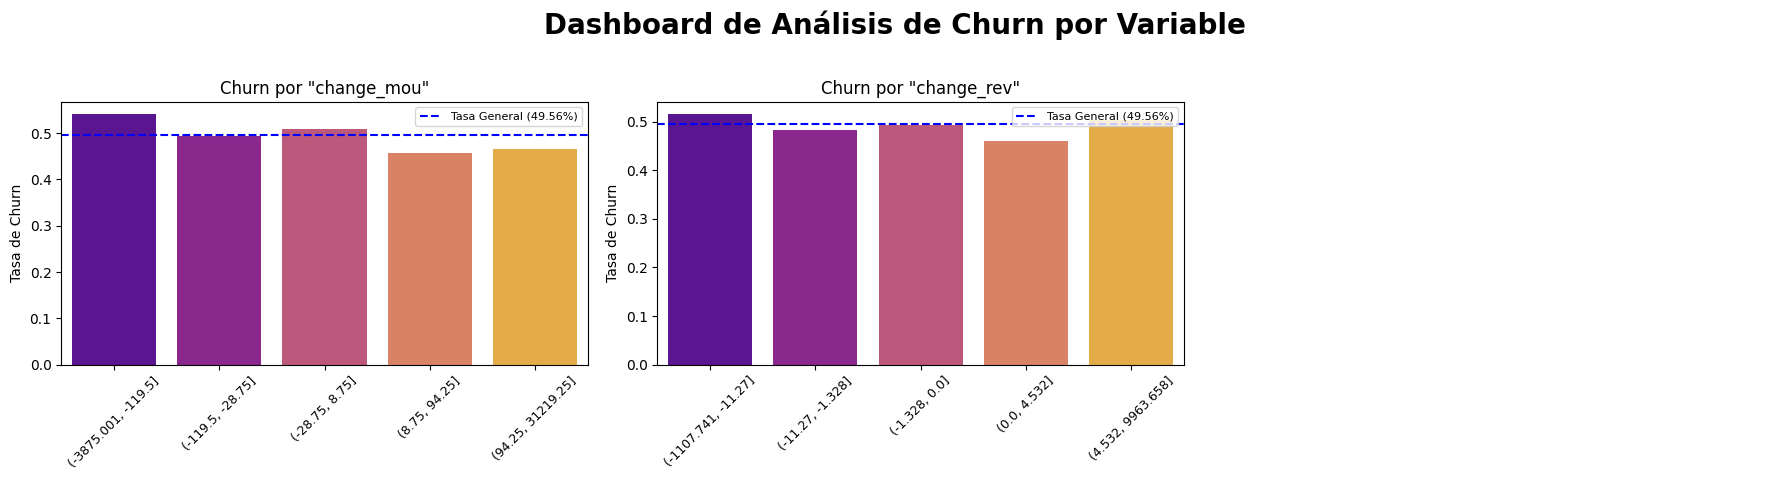

In [115]:
n_cols = len(['change_mou', 'change_rev'])

n_zayout_cols = 1  # Gráficos por fila (puedes cambiarlo a 2, 3, o 4)
n_layout_rows = (n_cols + n_layout_cols - 1) // n_layout_cols # Cálculo automático de filas

# 3. Crea la figura y los subplots
fig, axes = plt.subplots(n_layout_rows, n_layout_cols, figsize=(n_layout_cols * 6, n_layout_rows * 5))
fig.suptitle('Dashboard de Análisis de Churn por Variable', fontsize=20, weight='bold')

# 'axes' es una matriz de subplots, la aplanamos para iterar fácilmente
axes = axes.flatten()

for i, columna in enumerate(['change_mou', 'change_rev']):
    ax = axes[i]
    utils.plot_tasa_churn_numerica(df_limpio, columna, ax)

for i in range(n_cols, len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Ajustar para el título principal
plt.show()

Observamos que las personas cuyo uso ha aumentado mucho con respecto a los 3 meses anteriores (valores positivos [8,75-94.25] y [94.25-31219.25]) son personas con más lealtad y menos probabilidad de abandono. Sin embargo, la gente que ha disminuido su uso (con valores negativos de `change_mou`), tiene más probabilidad de abandonar, lo cual tiene sentido. Sin embargo, observamos que la gente cuyo pago ha aumentado mucho (valores muy positivos de `change_rev`), aumentan la probabilidad de abandono.

--- Análisis de Churn para la Variable Numérica: 'change_rev' ---


/home/paloma/churn-estimation/notebooks/utils.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(


Análisis por rangos:
                     Tasa de Churn  Total Clientes
change_rev_rango                                  
(-1107.741, -11.27]       0.514963           19815
(-11.27, -1.328]          0.482266           19821
(-1.328, 0.0]             0.492958           27266
(0.0, 4.532]              0.460374           12353
(4.532, 9963.658]         0.503054           19813




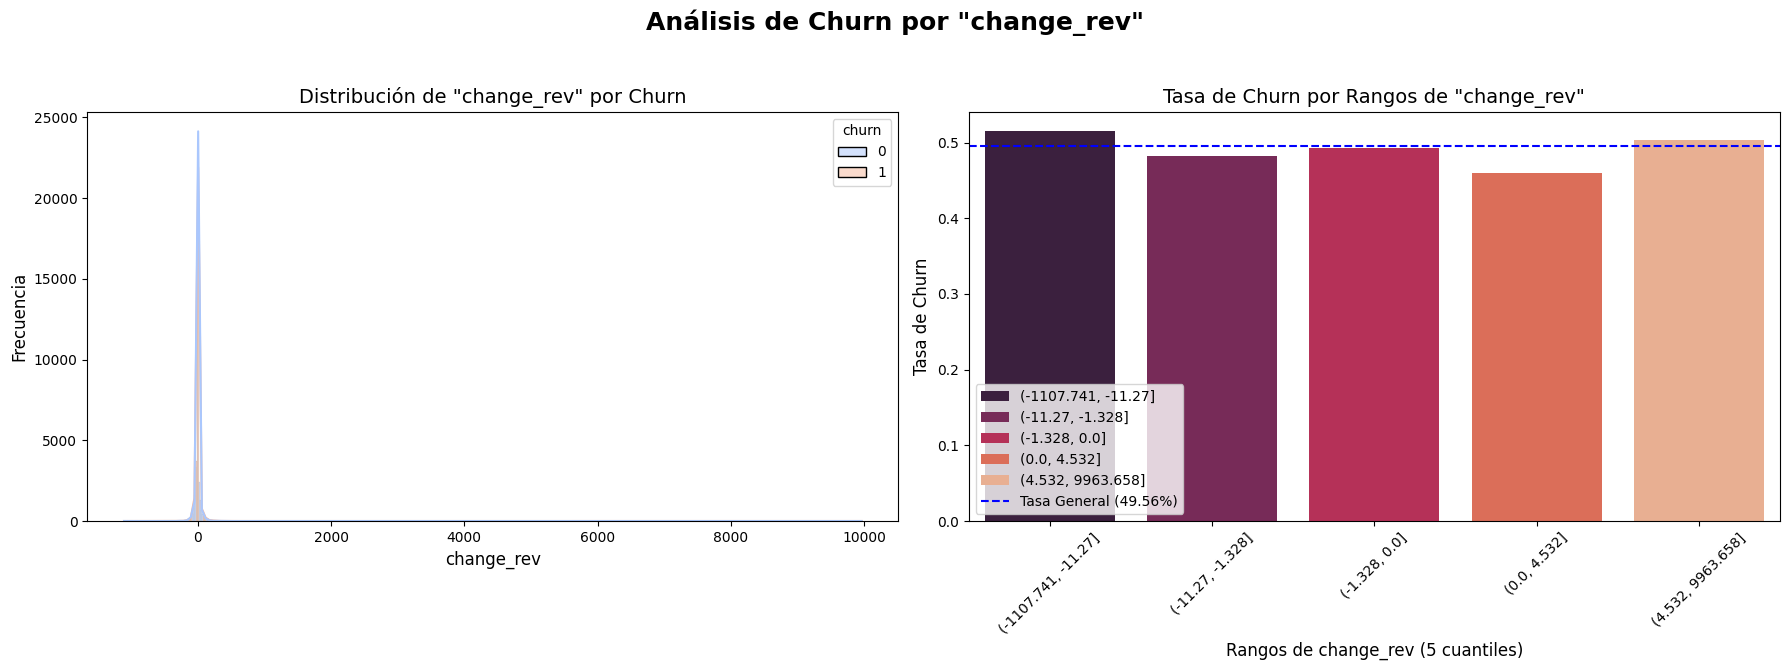

--- Análisis de Churn para la Variable Numérica: 'change_mou' ---


/home/paloma/churn-estimation/notebooks/utils.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_binned = df_copy.groupby(columna_binned)[target].agg(['mean', 'count']).rename(


Análisis por rangos:
                     Tasa de Churn  Total Clientes
change_mou_rango                                  
(-3875.001, -119.5]       0.540411           19846
(-119.5, -28.75]          0.493998           19828
(-28.75, 8.75]            0.508883           19814
(8.75, 94.25]             0.456033           19799
(94.25, 31219.25]         0.466407           19781




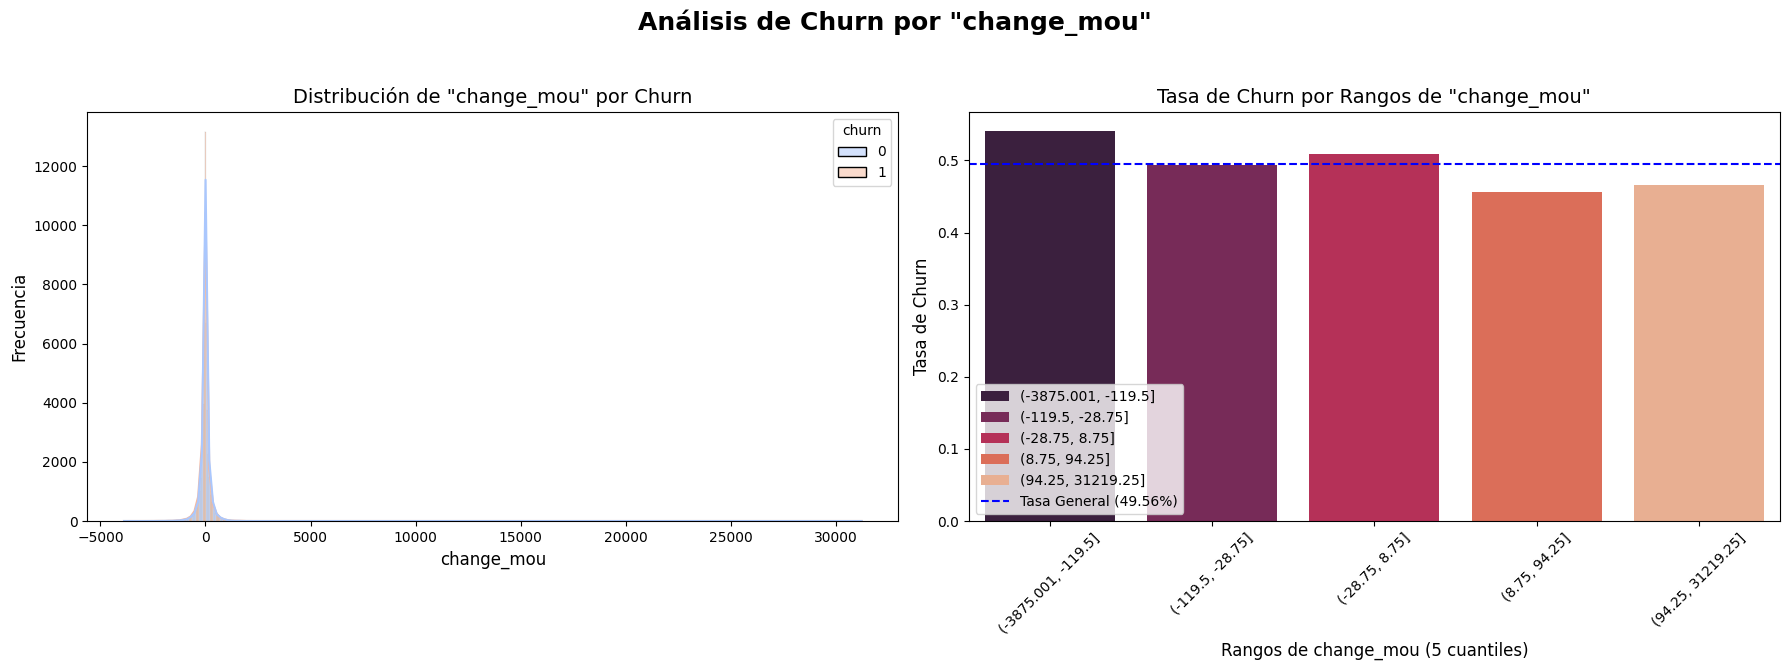

In [116]:
utils.analizar_churn_numerica(df_limpio, 'change_rev')
utils.analizar_churn_numerica(df_limpio, 'change_mou')

Observamos que una subida del uso también da lealtad, lo cual puede implicar servicios más de tarifa plana, cuyo aumento de uso no revierte en el cargo.

Tras este estudio, determinamos que imputamos estas variables por 0

In [117]:
df_limpio['change_mou'] = df_limpio['change_mou'].fillna(0)
df_limpio['change_rev'] = df_limpio['change_rev'].fillna(0)

null_info = utils.calcular_nulos(df_limpio)

print(null_info[null_info['Nulos']>0])

                  Nulos  Porcentaje
avg6mou            2837    2.838164
avg6qty            2837    2.838164
avg6rev            2837    2.838164
prizm_social_one   7386    7.389030
hnd_price           846    0.846347
hnd_webcap        10185   10.189178
ownrent           33694   33.707820
lor               30177   30.189378
dwlltype          31898   31.911084
adults            23010   23.019438
infobase          22070   22.079052
income            25426   25.436429
numbcars          49350   49.370242
HHstatin          37906   37.921548
dwllsize          38293   38.308707


### 4. Variable de media 6 meses

Número de 1s en la nueva columna flag: avg_null
1    2837
Name: count, dtype: int64

--- Análisis de Churn para la Variable Categórica: 'avg_null' ---
          Tasa de Churn  Total Clientes
avg_null                               
0              0.498301           97122
1              0.401833            2837




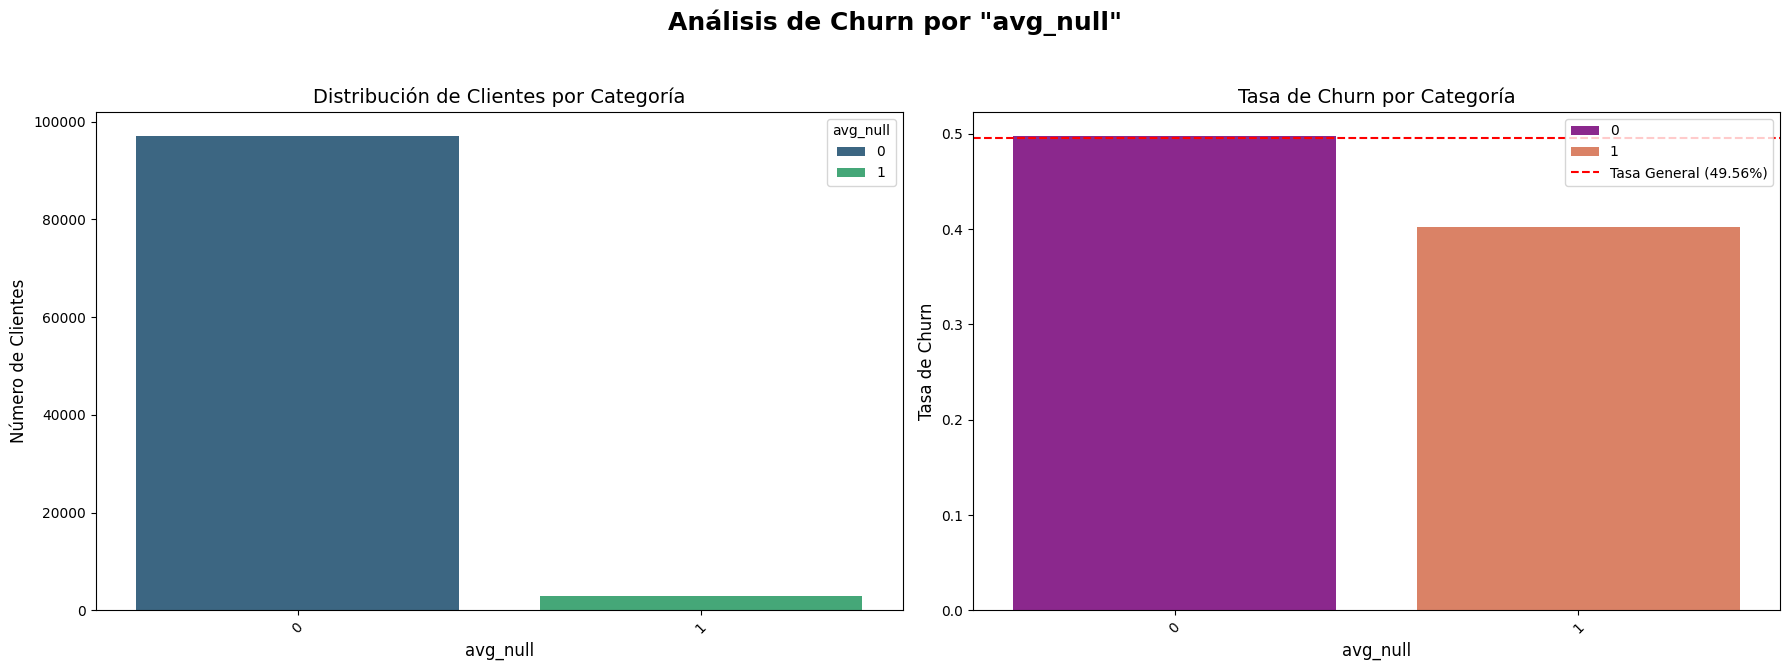

In [118]:
utils.crear_flag_nulos(df_limpio, 'avg6qty', 'avg_null')

utils.analizar_churn_categorica(df_limpio, 'avg_null')

Tener esta variable sin rellenar implica más fidelidad que el usuario medio. Vamos a ver cuánto tiempo llevan en la empresa estos usuarios.

In [119]:
df_avg_nulos = df_limpio[df_limpio['avg_null'] == 1]
df_avg_no_nulos = df_limpio[df_limpio['avg_null'] == 0]

print("--- Resumen de Antigüedad ('months') ---")

print("\nPara el grupo con 'avg' NULO (los supuestos 'legacy'):")
print(df_avg_nulos['months'].describe())

print("\nPara el grupo NORMAL:")
print(df_avg_no_nulos['months'].describe())

--- Resumen de Antigüedad ('months') ---

Para el grupo con 'avg' NULO (los supuestos 'legacy'):
count    2837.000000
mean        7.560451
std         4.743524
min         6.000000
25%         6.000000
50%         7.000000
75%         7.000000
max        60.000000
Name: months, dtype: float64

Para el grupo NORMAL:
count    97122.000000
mean        19.163629
std          9.565267
min          7.000000
25%         12.000000
50%         17.000000
75%         25.000000
max         61.000000
Name: months, dtype: float64


Hemos visto que los usuarios que no tienen este valor, tienen una media de permanencia en la empresa de 7 meses. Posiblemente, las variables `avg6` sólo se calculen sobre 6 meses más cerrados. Seguramente el máximo valor de 60 sea algún tipo de error. Por lo tanto, vamos a imputar este valor como 0 para estos nulos.

In [120]:
cols_avg6 = ['avg6qty', 'avg6rev', 'avg6mou']

df_limpio[cols_avg6] = df_limpio[cols_avg6].fillna(0)
print(df_limpio[cols_avg6].isnull().sum())

avg6qty    0
avg6rev    0
avg6mou    0
dtype: int64


### 5. Precio del handset

In [121]:
df_limpio['hnd_price'].describe()

count    99113.000000
mean       101.882376
std         61.009618
min          9.989998
25%         29.989990
50%         99.989990
75%        149.989990
max        499.989990
Name: hnd_price, dtype: float64

In [122]:
utils.crear_flag_nulos(df_limpio, 'hnd_price', 'hnd_price_null')


Número de 1s en la nueva columna flag: hnd_price_null
1    846
Name: count, dtype: int64



,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,kid16_17,creditcd,eqpdays,Customer_ID,services_null,cat_null,num_hijos_minimo,change_null,avg_null,hnd_price_null
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,U,Y,361.0,1000001,0,0,0,0,0,0
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,U,Y,240.0,1000002,0,0,0,0,0,1
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,U,Y,1504.0,1000003,0,0,1,0,0,0
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,U,Y,1812.0,1000004,0,0,1,0,0,0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,U,Y,434.0,1000005,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0000,0.00,0.000,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,U,Y,773.0,1099996,1,0,1,1,0,0
99996,0.0000,0.00,0.000,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,Y,Y,835.0,1099997,1,0,3,1,0,0
99997,0.0000,0.00,0.000,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,U,N,433.0,1099998,1,0,2,1,0,0
99998,0.0000,0.00,0.000,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,U,N,75.0,1099999,1,0,0,1,0,0


--- Análisis de Churn para la Variable Categórica: 'hnd_price_null' ---
                Tasa de Churn  Total Clientes
hnd_price_null                               
0                    0.496655           99113
1                    0.367612             846




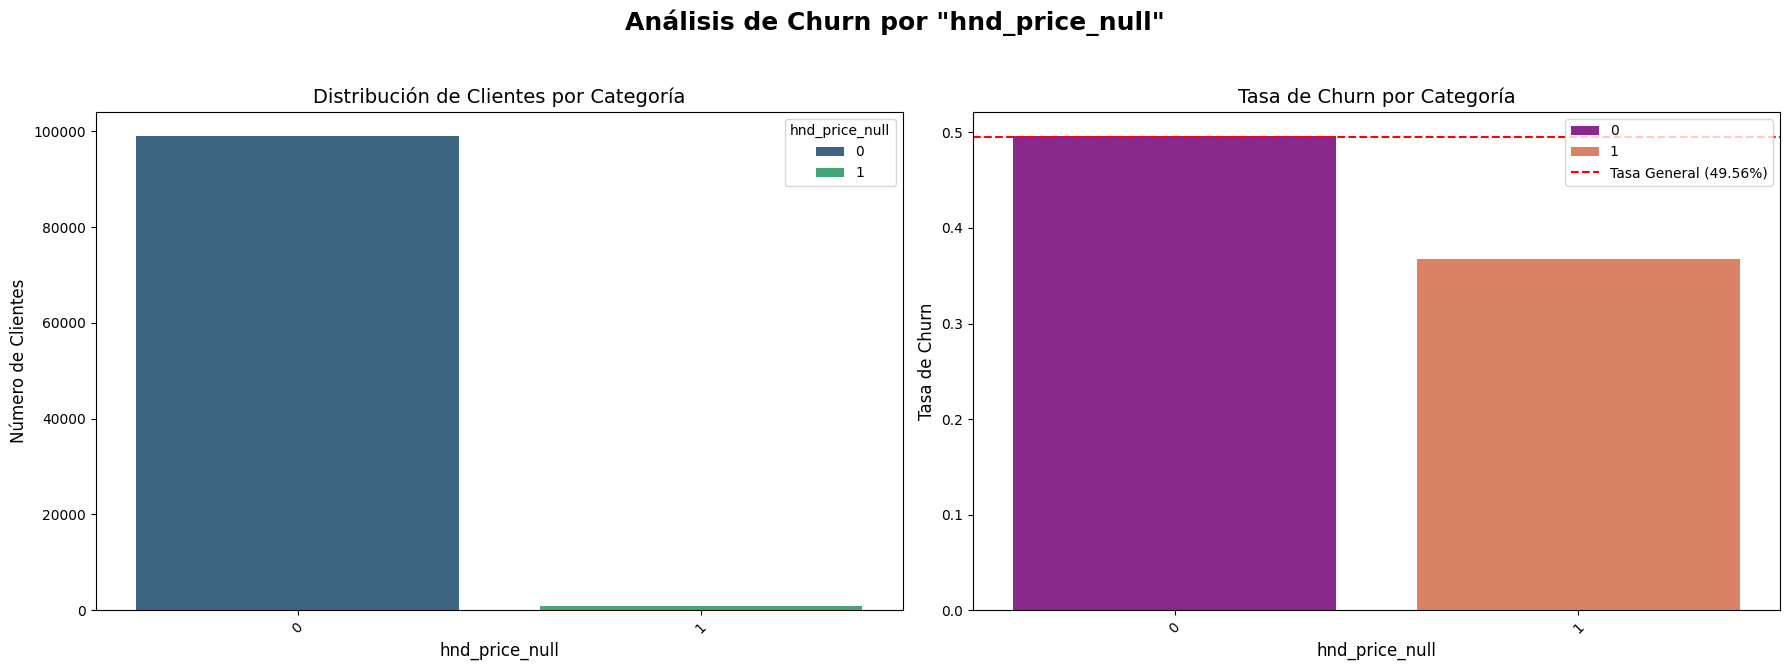

In [123]:
utils.analizar_churn_categorica(df_limpio, 'hnd_price_null')

De nuevo, tener el `hnd_price` vacío implica alta lealtad. Posiblemente puede ser porque hayan renovado el contrato para tener un nuevo dispositivo y no esté actualizado, o porque estén en un plan de empresa y el dispositivo no lo adquieran mediante esta compañía, si no por la suya.

Vamos a hacer una imputación por mediana.

In [124]:
valor_mediana = df_limpio['hnd_price'].median()
df_limpio['hnd_price'] = df_limpio['hnd_price'].fillna(valor_mediana)

### 6. Resto de nulos

In [125]:
null_info = utils.calcular_nulos(df_limpio)

print(null_info[null_info['Nulos']>0])

                  Nulos  Porcentaje
prizm_social_one   7386    7.389030
hnd_webcap        10185   10.189178
ownrent           33694   33.707820
lor               30177   30.189378
dwlltype          31898   31.911084
adults            23010   23.019438
infobase          22070   22.079052
income            25426   25.436429
numbcars          49350   49.370242
HHstatin          37906   37.921548
dwllsize          38293   38.308707


In [ ]:
categoricas = ['prizm_social_one', 'hnd_webcap', 'ownrent', 
    'dwlltype', 'infobase', 'HHstatin', 'dwllsize']

# Añadimos otra categoría llamada UNKN

for col in categoricas:
    if col in df_limpio.columns:
        df_limpio[f'flag_{col}_null'] = df_limpio[col].isnull().astype(int)
            
        df_limpio[col] = df_limpio[col].fillna('UNKN')
        
        print(f"-> Variable '{col}' gestionada.")

null_info = utils.calcular_nulos(df_limpio)

print(null_info[null_info['Nulos']>0])

-> Variable 'prizm_social_one' gestionada.
-> Variable 'hnd_webcap' gestionada.
-> Variable 'ownrent' gestionada.
-> Variable 'dwlltype' gestionada.
-> Variable 'infobase' gestionada.
-> Variable 'HHstatin' gestionada.
-> Variable 'dwllsize' gestionada.
          Nulos  Porcentaje
lor       30177   30.189378
adults    23010   23.019438
income    25426   25.436429
numbcars  49350   49.370242


/tmp/ipykernel_7877/2549371463.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_limpio[col].fillna('UNKN', inplace=True)
/tmp/ipykernel_7877/2549371463.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi